# Food Demand Forecasting

### _Overview_  
Food centers face the problem of either purchasing more than they need for the week and waste food, or they risk having food shortage for the week. Forecasting the potential number of orders per week can greatly benefit the centers and provide a solution to this dilemma.  

In this dataset, it contains data about each fulfillment center per week for 145 weeks. Each week, all the centers send in data about what they have purchased, the price, other information and then the number of orders they ended up having.  

Our goal will be to help predict the following weeks and try to determine the number of orders the centers can be expecting each week.

### _Data Definitions_

#### train.csv
id: Unique ID  
week: Week Number  
center_id: Unique ID for fulfillment center  
meal_id: Unique ID for Meal  
checkout_price: Final price including discount, taxes & delivery charges  
base_price: Base price of the meal  
emailer_for_promotion: Emailer sent for promotion of meal  
homepage_featured: Meal featured on homepage  
**TARGET** num_orders: Orders Count  

#### meal_info.csv
meal_id: Unique ID for the meal  
category: Type of meal (beverages/snacks/soups/etc)  
cuisine: Meal cuisine (Indian/Italian/etc)  

#### fulfilment_center_info.csv
center_id: Unique ID for fulfillment center  
city_code: Unique code for city  
region_code: Unique code for region  
center_type: Anonymized center type  
op_area: Area of operation (in km^2)  

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train = pd.read_csv('food_forecasting_train/train.csv')
meal_info = pd.read_csv('food_forecasting_train/meal_info.csv')
ff_center = pd.read_csv('food_forecasting_train/fulfilment_center_info.csv')

test = pd.read_csv('food_test_data.csv')

# Data Cleaning

### meal_info data cleaning  
We can check for missing values by examining the number of rows in each column.

In [5]:
meal_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
meal_id     51 non-null int64
category    51 non-null object
cuisine     51 non-null object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


They all have the same number of rows meaning no missing values and datatypes look reasonable.  
Next let's see what values are in the columns. Make sure there are no strange values!

In [6]:
for i in meal_info.columns:
    print(meal_info[i].unique())

[1885 1993 2539 1248 2631 1311 1062 1778 1803 1198 2707 1847 1438 2494
 2760 2490 1109 2290 1525 2704 1878 2640 2577 1754 1971 2306 2139 2826
 2664 2569 1230 1207 2322 2492 1216 1727 1902 1247 2304 1543 1770 2126
 1558 2581 1962 1571 2956 2104 2444 2867 1445]
['Beverages' 'Extras' 'Soup' 'Other Snacks' 'Salad' 'Rice Bowl' 'Starters'
 'Sandwich' 'Pasta' 'Desert' 'Biryani' 'Pizza' 'Fish' 'Seafood']
['Thai' 'Indian' 'Italian' 'Continental']


### ff_center data cleaning  
Check for missing values by looking at the number of rows once more.

In [7]:
ff_center.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
center_id      77 non-null int64
city_code      77 non-null int64
region_code    77 non-null int64
center_type    77 non-null object
op_area        77 non-null float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.1+ KB


In [8]:
ff_center.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [9]:
for i in ff_center.columns:
    print(ff_center[i].unique())

[ 11  13 124  66  94  64 129 139  88 143 101  86  32 149 152  92  27  14
  26 104  77  23  97 146 113 145  80  55 186  99  91  20 106  81  73  29
  43 102  61  50  83  57 126 177  67 174  59  58  65  39 132  89 162  75
  72  41  10 110  52  93  74  34 137 153  24 109 108  36 157  17 161  42
  53  30  76  68  51]
[679 590 648 632 553 593 693 526 562 699 478 576 713 654 515 647 676 698
 628 680 620 604 649 596 522 675 473 556 659 541 577 683 638 700 456 695
 602 703 651 485 685 461 702 615 614 599 579 517 609 658 561]
[56 34 77 85 23 71 35 93]
['TYPE_A' 'TYPE_B' 'TYPE_C']
[3.7 6.7 4.  4.1 3.6 4.4 3.9 2.8 3.8 2.4 2.9 4.5 2.7 3.  3.4 4.6 5.  5.1
 2.  0.9 4.8 5.3 7.  4.2 4.7 1.9 6.3 5.6 3.2 3.5]


Datatypes are logical and no missing values.

### train/test data cleaning

In [10]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
id                       456548 non-null int64
week                     456548 non-null int64
center_id                456548 non-null int64
meal_id                  456548 non-null int64
checkout_price           456548 non-null float64
base_price               456548 non-null float64
emailer_for_promotion    456548 non-null int64
homepage_featured        456548 non-null int64
num_orders               456548 non-null int64
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


Datatypes are logical and no missing values.

In [12]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32573 entries, 0 to 32572
Data columns (total 8 columns):
id                       32573 non-null int64
week                     32573 non-null int64
center_id                32573 non-null int64
meal_id                  32573 non-null int64
checkout_price           32573 non-null float64
base_price               32573 non-null float64
emailer_for_promotion    32573 non-null int64
homepage_featured        32573 non-null int64
dtypes: float64(2), int64(6)
memory usage: 2.0 MB


Datatypes are logical and no missing values.

In [14]:
train_meal = pd.merge(train, meal_info, how='right', on='meal_id')
test_meal = pd.merge(test, meal_info, how='right', on='meal_id')
train_meal.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai
1,1040403,1,24,1885,136.83,136.83,0,0,1498,Beverages,Thai
2,1103215,1,11,1885,136.83,136.83,0,0,959,Beverages,Thai
3,1034383,1,83,1885,121.31,120.31,0,1,1025,Beverages,Thai
4,1118999,1,32,1885,114.52,113.52,0,1,445,Beverages,Thai


In [15]:
train_full = pd.merge(train_meal, ff_center, how='right', on='center_id')
test_full = pd.merge(test_meal, ff_center, how='right', on='center_id')
print(train_full.shape)
train_full.head()

(456548, 15)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1018704,2,55,1885,135.83,152.29,0,0,323,Beverages,Thai,647,56,TYPE_C,2.0
2,1196273,3,55,1885,132.92,133.92,0,0,96,Beverages,Thai,647,56,TYPE_C,2.0
3,1116527,4,55,1885,135.86,134.86,0,0,163,Beverages,Thai,647,56,TYPE_C,2.0
4,1343872,5,55,1885,146.50,147.50,0,0,215,Beverages,Thai,647,56,TYPE_C,2.0


In [16]:
print(test_full.shape)
test_full.head()

(32573, 14)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area
0,1028232,146,55,1885,158.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0
1,1262649,147,55,1885,159.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0
2,1453211,149,55,1885,157.14,158.14,0,0,Beverages,Thai,647,56,TYPE_C,2.0
3,1262599,150,55,1885,159.14,157.14,0,0,Beverages,Thai,647,56,TYPE_C,2.0
4,1495848,151,55,1885,160.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0


# Before EDA  
We have to remember that *time* is dependent here! The data has a week column, measurements are made weekly and determined weekly.  
Thus we cannot approach this dataset the normal linear way since linear regression assumes independent variables.  

### Hypotheses  
We can come up with some hypotheses before looking at the data further and see if we can confirm these through data exploration!  

1. Number of orders will increase overall as the week goes by.  
   * Explanation: Simply because in general, population is on the rise, expecting more people.  
2. Different regions will have one cuisine that is their number one seller.  
   * Explanation: Different population clusters will enjoy different types of food.  
3. Meals featured on the home page will have more orders.  
   * Explanation: More exposure to people will help it be noticed more.  
4. Bigger area of operation will have more orders.
   * Explanation: Bigger centers will likely have more traffic and thus more orders.


# EDA

In [17]:
train_clean = train_full.drop('id', axis=1)

In [18]:
train_clean.describe()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area
count,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000,456548.000000,456548.000000,456548.000000
mean,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.10920,261.872760,601.553399,56.614566,4.083590
std,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.31189,395.922798,66.195914,17.641306,1.091686
min,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.00000,13.000000,456.000000,23.000000,0.900000
25%,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.00000,54.000000,553.000000,34.000000,3.600000
50%,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.00000,136.000000,596.000000,56.000000,4.000000
75%,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.00000,324.000000,651.000000,77.000000,4.500000
max,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.00000,24299.000000,713.000000,93.000000,7.000000


In [19]:
print('center id number of unique values: ', train_clean['center_id'].nunique())
print('city code number of unique values: ', train_clean['city_code'].nunique())
print('region code number of unique values: ', train_clean['region_code'].nunique())

center id number of unique values:  77
city code number of unique values:  51
region code number of unique values:  8


At first glance, it might seem like the combination of center id, city code, and region code are the same. However, looking at the number of unique values for each column, it is clear that there are overlaps.

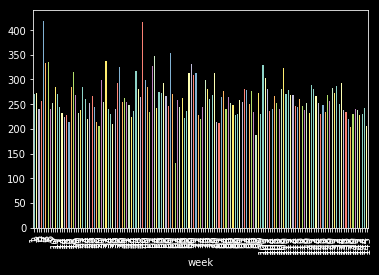

In [20]:
train_clean.groupby('week')['num_orders'].mean().plot.bar()

The graph above is plotting the average number of orders per week. It would appear our first hypothesis might not be correct! It does not have an upper trend although there are two big spikes and a really low point.

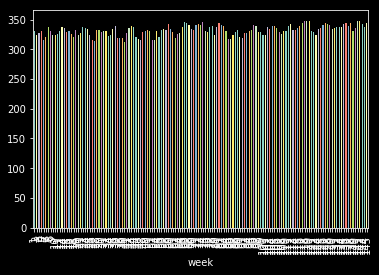

In [21]:
train_clean.groupby('week')['checkout_price'].mean().plot.bar()

Seems like the price of the meal is pretty constant through the weeks.  
This is meeting the first criteria that the data time series is stationary (the mean is constant).  

Let's see if the variance is constant over time.

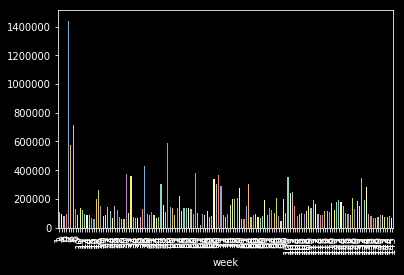

In [22]:
train_clean.groupby('week').var()['num_orders'].plot.bar()

There are some really high spikes in value. It could indicate that this is a non-stationary time series.

In [24]:
train_clean.groupby(['region_code', 'cuisine']).sum()['num_orders']

region_code  cuisine    
23           Continental      243365
             Indian           339949
             Italian          640670
             Thai             385922
34           Continental     3863230
             Indian          5745894
             Italian         9501031
             Thai            4941578
35           Continental      148610
             Indian           149745
             Italian          268946
             Thai             123743
56           Continental     7602181
             Indian         12317486
             Italian        21292158
             Thai           19308366
71           Continental      339814
             Indian           438420
             Italian          820732
             Thai             504316
77           Continental     3221464
             Indian          4745419
             Italian         7917770
             Thai            4645000
85           Continental     1272281
             Indian          1784986
             

It would seem Italian is consistently the top category of orders, with Thai food being second and Continental being the less ordered in almost all regions.

In [25]:
train_clean.groupby(['meal_id', 'homepage_featured'])['num_orders'].sum()

meal_id  homepage_featured
1062     0                    4518261
         1                     194534
1109     0                    4957163
         1                    1410610
1198     0                    1008383
         1                       9897
1207     0                    1368566
         1                     432290
1216     0                     503607
         1                      29957
1230     0                    1412461
         1                     431508
1247     0                     231187
         1                        710
1248     0                     701516
         1                     173234
1311     0                    1459509
         1                      30172
1438     0                     363705
         1                      31379
1445     0                     656967
         1                     402254
1525     0                    1119297
         1                     600081
1543     0                     640898
         1             

Being featured on the homepage did not particularly increase orders.

In [26]:
train_clean.groupby('category')['num_orders'].sum().sort_values()

category
Biryani           631848
Fish              871959
Soup             1039646
Pasta            1637744
Desert           1940754
Seafood          2715714
Extras           3984979
Starters         4649122
Other Snacks     4766293
Pizza            7383720
Salad           10944336
Sandwich        17636782
Rice Bowl       20874063
Beverages       40480525
Name: num_orders, dtype: int64

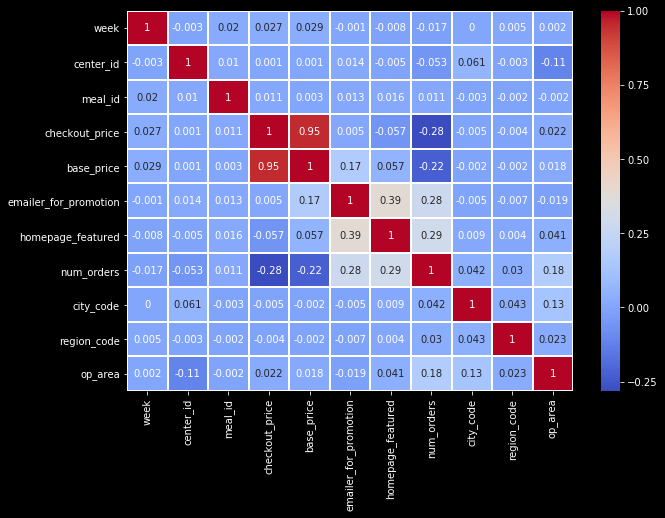

In [27]:
plt.figure(figsize=(10,7))
sns.heatmap(round(train_clean.corr(),3), cmap='coolwarm', linewidths=1, annot=True)

# Train/Validate

Since this dataset is a time series, we will not be randomly splitting the data into training and validation. This is because if it random takes the earliest and the latest data to train, then validates the middle portion, the training set essentially had a data leak of future data.  
Thus we will be using the most recent 35 weeks as validation set in order to ensure there are enough data points still for the training set.

In [28]:
train_set = train_clean[train_clean['week'] <= 115].copy()
val_set = train_clean[train_clean['week'] > 115].copy()

print('training set: ', train_set.shape)
print('validation set: ', val_set.shape)

training set:  (358073, 14)
validation set:  (98475, 14)


In [49]:
predict_col = np.array(train_clean.groupby('week').sum()['num_orders'])

y_hat = val_set.copy()
y_hat['naive'] = predict_col[len(predict_col)-1]
y_hat['naive'].head()

115    671926
116    671926
117    671926
118    671926
119    671926
Name: naive, dtype: int64

In [50]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(val_set['num_orders'], y_hat['naive']))
print(rms)

671677.5655381841


Clearly, the naive approach does not work because this is not yet a stationary time series.